Research Question:
What set of factors is most important in determining adult violent crime rates across U.S. states from 2013-2018? How could we use these factors to accurately predict future violent crime rates?

sources:
using inplace for the rename function: https://www.geeksforgeeks.org/what-does-inplace-mean-in-pandas/

In [173]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import duckdb

Data Overview: 
Jasmine

Data Cleaning

In [174]:
East = ["Maine", "New Hampshire", "Rhode Island", 'Connecticut',
        'New York', 'Massachusetts', 'New jersey', 'Florida', 'Georgia',
        'Maryland', 'North Carolina', 'South Carolina', 'Virginia'
        ]
West = ['Alaska', 'Washington', 'Oregon', 'California', 'Hawaii',
        'Utah', 'Idaho', 'Monatana', 'Nevada']

In [175]:
#loading crime data
crime_df = pd.read_csv('data/crime.csv')
print(crime_df.iloc[:, 2:])

      Unnamed: 2  Unnamed: 3     Unnamed: 4 Unnamed: 5   Unnamed: 6  \
0     state_name  population  violent_crime   homicide  rape_legacy   
1            NaN   220099000        1208030      21460        76390   
2         Alaska      406000           1994         54          292   
3        Alabama     3769000          15578        496         1037   
4       Arkansas     2180000           7984        198          595   
...          ...         ...            ...        ...          ...   
2332         NaN   8,715,698         20,589        520          NaN   
2333         NaN   7,812,880         27,909        373          NaN   
2334         NaN   1,770,071          4,699         87          NaN   
2335         NaN   5,910,955         17,057        283          NaN   
2336         NaN     584,057          1,116         18          NaN   

        Unnamed: 7 Unnamed: 8          Unnamed: 9     Unnamed: 10 Unnamed: 11  \
0     rape_revised    robbery  aggravated_assault  property_crime 

In [176]:
#see what the names of each column are without any edits to the csv
print(crime_df.columns)

#rename the columns we want with proper names
crime_df.rename(columns={
    'estimated_crimes_1979_2023': 'Year',
    'Unnamed: 1': 'State_Abbreviation',
    'Unnamed: 2': 'State_Name',
    'Unnamed: 3': 'Population',
    'Unnamed: 4': 'Violent_Crime',
    'Unnamed: 5': 'Homicide',
    'Unnamed: 6': 'Rape',
    'Unnamed: 7': 'Rape_Revised',
    'Unnamed: 8': 'Robbery',
    'Unnamed: 9': 'Aggravated_Assault'
},inplace=True)

#drop columns that will not be used during the analysis
crime_df = crime_df.drop(columns=['Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12',
       'Unnamed: 13', 'Unnamed: 14'])
print(crime_df)


Index(['estimated_crimes_1979_2023', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3',
       'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8',
       'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12',
       'Unnamed: 13', 'Unnamed: 14'],
      dtype='object')
      Year State_Abbreviation  State_Name  Population  Violent_Crime  \
0     year         state_abbr  state_name  population  violent_crime   
1     1979                NaN         NaN   220099000        1208030   
2     1979                 AK      Alaska      406000           1994   
3     1979                 AL     Alabama     3769000          15578   
4     1979                 AR    Arkansas     2180000           7984   
...    ...                ...         ...         ...            ...   
2332  2023                 VA         NaN   8,715,698         20,589   
2333  2023                 WA         NaN   7,812,880         27,909   
2334  2023                 WV         NaN   1,770,071          4,699  

In [177]:
#dropping the first row (index 0) and reset the indexes. This way, I can turn the year from object to integer.
crime_df = crime_df.drop(index=0)


In [178]:
#if rape_Revised is na, take rape
na_rape_values = crime_df['Rape'].loc[crime_df['Rape_Revised'].isna()] #put this into rape_revised

crime_df['Rape_Revised'] = crime_df['Rape_Revised'].fillna(na_rape_values)

crime_df = crime_df.drop(columns = ['Rape'])

crime_df.rename(columns= {'Rape_Revised':'Rape'}, inplace=True)
crime_df.head()

,Year,State_Abbreviation,State_Name,Population,Violent_Crime,Homicide,Rape,Robbery,Aggravated_Assault
1,1979,NaN,NaN,220099000,1208030,21460,76390,480700,629480
2,1979,AK,Alaska,406000,1994,54,292,445,1203
3,1979,AL,Alabama,3769000,15578,496,1037,4127,9918
4,1979,AR,Arkansas,2180000,7984,198,595,1626,5565
5,1979,AZ,Arizona,2450000,14528,219,1120,4305,8884


In [179]:
# Reset the index
crime_df.reset_index(drop=True, inplace=True)

#making the year into an interger from an object
crime_df['Year']=crime_df['Year'].astype(int)

#shaping the data set so that we are only looking at years 2013 to 2018
crime_filtered_years = crime_df[(crime_df['Year'] >= 2013) & (crime_df['Year'] <= 2018)]

# Drop rows where 'State_Abbreviation' or 'State_Name' is NaN
crime_filtered_years = crime_filtered_years.dropna(subset=['State_Abbreviation', 'State_Name'])
crime_filtered_years.reset_index(inplace=True, drop = True)
print(crime_filtered_years)

     Year State_Abbreviation     State_Name Population Violent_Crime Homicide  \
0    2013                 AK         Alaska     737259          4709       34   
1    2013                 AL        Alabama    4833996         20834      346   
2    2013                 AR       Arkansas    2958765         13705      158   
3    2013                 AZ        Arizona    6634997         27576      355   
4    2013                 CA     California   38431393        154739     1746   
..    ...                ...            ...        ...           ...      ...   
301  2018                 VT        Vermont     624358          1155       11   
302  2018                 WA     Washington    7523869         23719      236   
303  2018                 WI      Wisconsin    5807406         17365      175   
304  2018                 WV  West Virginia    1804291          5411       76   
305  2018                 WY        Wyoming     577601          1235       14   

      Rape Robbery Aggravat

In [180]:
crime_filtered_years['Population'] = crime_filtered_years['Population'].astype(int)
crime_filtered_years['Rape'] = crime_filtered_years['Rape'].astype(int)
crime_filtered_years['Robbery'] = crime_filtered_years['Robbery'].astype(int)
crime_filtered_years['Aggravated_Assault'] = crime_filtered_years['Aggravated_Assault'].astype(int)
crime_filtered_years['Violent_Crime'] = crime_filtered_years['Violent_Crime'].astype(int)
crime_filtered_years['Homicide'] = crime_filtered_years['Homicide'].astype(int)
crime_filtered_years.dtypes

Year                   int64
State_Abbreviation    object
State_Name            object
Population             int64
Violent_Crime          int64
Homicide               int64
Rape                   int64
Robbery                int64
Aggravated_Assault     int64
dtype: object

In [181]:
crime_filtered_years['Sum'] = crime_filtered_years['Rape'] + crime_filtered_years['Robbery'] + \
  crime_filtered_years['Aggravated_Assault']+crime_filtered_years['Homicide']
crime_df = crime_filtered_years
print(crime_df.loc[:,['Violent_Crime','Sum']])

     Violent_Crime     Sum
0             4709    4709
1            20834   20834
2            13705   13705
3            27576   27576
4           154739  154739
..             ...     ...
301           1155    1155
302          23719   23719
303          17365   17365
304           5411    5411
305           1235    1235

[306 rows x 2 columns]


In [182]:
#loading poverty data
poverty_df = pd.read_csv('data/poverty.csv')
print(poverty_df)

                                             Unnamed: 0        Unnamed: 1  \
0     Table 19. Number of Poor and Poverty Rate by S...               NaN   
1     (Population in thousands. Population as of Mar...               NaN   
2                                                  2023               NaN   
3                                                 State  Total population   
4                                               Alabama             4,995   
...                                                 ...               ...   
2437                                      West Virginia             1,952   
2438                                          Wisconsin             4,724   
2439                                            Wyoming               468   
2440  Source: U.S. Census Bureau, Current Population...               NaN   
2441  Footnotes are available at <www.census.gov/top...               NaN   

             Unnamed: 2                Unnamed: 3          Unnamed: 4  \
0 

In [183]:
#cleaning the first few rows that are just words
poverty_df = poverty_df.drop([0, 1])

poverty_df.rename(columns={'Unnamed: 0':'State',
                           'Unnamed: 1': 'TotalPop',
                           'Unnamed: 2':'PovertyTotal',
                           'Unnamed: 3': 'Margin_1',
                           'Unnamed: 4': 'PovertyPercent',
                           'Unnamed: 5': "Margin_2"}, inplace=True)
#print(poverty_df.columns)
#cutting off any row that is not between 2013 and 2018
index_2018 = poverty_df[poverty_df['State'] == '2018'].index[0]
index_2017 = poverty_df[poverty_df['State'] == '2017 (3)'].index[0]
print(index_2018)
print(index_2017)


267
320


In [184]:
poverty_2018 = poverty_df[index_2018:index_2017-2]
print(poverty_2018.head())
print(poverty_2018.tail())

          State TotalPop PovertyTotal Margin_1 PovertyPercent Margin_2
269     Alabama    4,877          779      107           16.0      2.1
270      Alaska      720           94       15           13.1      2.0
271     Arizona    7,241          929      132           12.8      1.8
272    Arkansas    2,912          462       63           15.9      2.1
273  California   39,150        4,664      303           11.9      0.8
             State TotalPop PovertyTotal Margin_1 PovertyPercent Margin_2
315       Virginia    8,393          821      141            9.8      1.6
316     Washington    7,555          647      166            8.6      2.1
317  West Virginia    1,762          279       35           15.9      2.0
318      Wisconsin    5,795          499       89            8.6      1.5
319        Wyoming      565           53       10            9.5      1.8


In [185]:
index_2017 = poverty_df[poverty_df['State'] == '2017'].index[0]
index_2016 = poverty_df[poverty_df['State'] == '2016'].index[0]
print(index_2017)
print(index_2016)
poverty_2017 = poverty_df[index_2017:index_2016-2]
print(poverty_2017.tail())
#print(poverty_2017.tail(53))

373
426
             State TotalPop PovertyTotal Margin_1 PovertyPercent Margin_2
421       Virginia    8,249          847      127           10.3      1.5
422     Washington    7,431          736      104            9.9      1.5
423  West Virginia    1,794          311       46           17.3      2.5
424      Wisconsin    5,808          551       71            9.5      1.2
425        Wyoming      560           70       13           12.4      2.3


In [186]:
index_2015 = poverty_df[poverty_df['State'] == '2015'].index[0]

poverty_2016 = poverty_df[index_2016:index_2015-2]
print(poverty_2016.head())
print(poverty_2016.tail())

          State TotalPop PovertyTotal Margin_1 PovertyPercent Margin_2
428     Alabama    4,821          782      104           16.2      2.1
429      Alaska      708           89       20           12.6      2.8
430     Arizona    6,878        1,108      130           16.1      1.8
431    Arkansas    2,941          471       46           16.0      1.5
432  California   39,140        5,435      288           13.9      0.7
             State TotalPop PovertyTotal Margin_1 PovertyPercent Margin_2
474       Virginia    8,163          929      137           11.4      1.6
475     Washington    7,289          800       99           11.0      1.3
476  West Virginia    1,808          326       51           18.0      2.8
477      Wisconsin    5,764          620       84           10.7      1.5
478        Wyoming      571           62       12           10.9      2.0


In [187]:
index_2014 = poverty_df[poverty_df['State'] == '2014'].index[0]

poverty_2015 = poverty_df[index_2015:index_2014-2]
print(poverty_2015.head())
print(poverty_2015.tail())

          State TotalPop PovertyTotal Margin_1 PovertyPercent Margin_2
481     Alabama    4,820          784       99           16.3      2.0
482      Alaska      703           65       10            9.2      1.5
483     Arizona    6,728        1,156      138           17.2      2.1
484    Arkansas    2,951          475       44           16.1      1.5
485  California   39,080        5,441      347           13.9      0.8
             State TotalPop PovertyTotal Margin_1 PovertyPercent Margin_2
527       Virginia    8,216          894      133           10.9      1.6
528     Washington    7,193          819       89           11.4      1.3
529  West Virginia    1,795          261       76           14.5      4.3
530      Wisconsin    5,736          654      112           11.4      2.0
531        Wyoming      574           56       13            9.8      2.3


In [188]:
index_2013 = poverty_df[poverty_df['State'] == '2013 (4)'].index[0]
poverty_2014 = poverty_df[index_2014:index_2013-2]
print(poverty_2014.head())
print(poverty_2014.tail())

          State TotalPop PovertyTotal Margin_1 PovertyPercent Margin_2
534     Alabama    4,765          848       87           17.8      1.8
535      Alaska      694           82       13           11.9      2.0
536     Arizona    6,657        1,409      125           21.2      1.8
537    Arkansas    2,891          532       72           18.4      2.5
538  California   38,670        6,112      359           15.8      1.0
             State TotalPop PovertyTotal Margin_1 PovertyPercent Margin_2
580       Virginia    8,257          842      120           10.2      1.5
581     Washington    7,079          852      135           12.0      2.0
582  West Virginia    1,822          376       49           20.6      2.8
583      Wisconsin    5,742          628       90           10.9      1.6
584        Wyoming      572           55       10            9.7      1.8


In [189]:
index_2013 = poverty_df[poverty_df['State'] == '2013 (5)'].index[0]
index_2012 = poverty_df[poverty_df['State'] == '2012'].index[0]
poverty_2013 = poverty_df[index_2013:index_2012-2]
print(poverty_2013.head())
print(poverty_2013.tail())


          State TotalPop PovertyTotal Margin_1 PovertyPercent Margin_2
640     Alabama    4,751          796      110           16.7      2.3
641      Alaska      696           76       20           10.9      2.8
642     Arizona    6,645        1,345      153           20.2      2.3
643    Arkansas    2,940          504      114           17.1      3.9
644  California   38,050        5,675      352           14.9      1.0
             State TotalPop PovertyTotal Margin_1 PovertyPercent Margin_2
686       Virginia    8,174          854      165           10.4      2.0
687     Washington    6,854          819      133           12.0      2.0
688  West Virginia    1,823          315       58           17.3      3.1
689      Wisconsin    5,625          618      115           11.0      2.0
690        Wyoming      578           68       10           11.8      1.8


In [190]:
poverty_2018 = poverty_2018.copy()
poverty_2018['Year'] = 2018
poverty_2017 = poverty_2017.copy()
poverty_2017['Year'] = 2017
poverty_2016= poverty_2016.copy()
poverty_2016['Year'] = 2016
poverty_2015 = poverty_2015.copy()
poverty_2015['Year'] = 2015
poverty_2014 = poverty_2014.copy()
poverty_2014['Year'] = 2014
poverty_2013 = poverty_2013.copy()
poverty_2013['Year'] = 2013

poverty_concat = pd.concat([poverty_2013, poverty_2014, poverty_2015, poverty_2016, poverty_2017, poverty_2018], axis=0)
poverty_concat.reset_index(inplace=True, drop=True)
print(poverty_concat)


             State TotalPop PovertyTotal Margin_1 PovertyPercent Margin_2  \
0          Alabama    4,751          796      110           16.7      2.3   
1           Alaska      696           76       20           10.9      2.8   
2          Arizona    6,645        1,345      153           20.2      2.3   
3         Arkansas    2,940          504      114           17.1      3.9   
4       California   38,050        5,675      352           14.9      1.0   
..             ...      ...          ...      ...            ...      ...   
301       Virginia    8,393          821      141            9.8      1.6   
302     Washington    7,555          647      166            8.6      2.1   
303  West Virginia    1,762          279       35           15.9      2.0   
304      Wisconsin    5,795          499       89            8.6      1.5   
305        Wyoming      565           53       10            9.5      1.8   

     Year  
0    2013  
1    2013  
2    2013  
3    2013  
4    2013  
.. 

In [191]:
poverty_concat['PovertyTotal'] = poverty_concat.PovertyTotal.str.replace(",", '').astype(int)
poverty_concat['Margin_1'] = poverty_concat['Margin_1'].astype(float)
poverty_concat['Margin_2'] = poverty_concat['Margin_2'].astype(float)
poverty_concat['PovertyPercent'] = poverty_concat['PovertyPercent'].astype(float)
poverty_concat['TotalPop'] = poverty_concat.TotalPop.str.replace(",", '').astype(int)
poverty_concat.dtypes


State              object
TotalPop            int64
PovertyTotal        int64
Margin_1          float64
PovertyPercent    float64
Margin_2          float64
Year                int64
dtype: object

In [192]:
pop_df = pd.read_csv('data/population.csv', thousands = ',')
pop_df.head()

,table with row headers in column A and column headers in rows 3 through 4. (leading dots indicate sub-parts),Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,Table 1. Annual Estimates of the Resident Popu...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Geographic Area,"April 1, 2010",NaN,Population Estimate (as of July 1),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,Census,Estimates Base,2010,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0
3,United States,"308,745,538","308,758,105","309,321,666",311556874.0,313830990.0,315993715.0,318301008.0,320635163.0,322941311.0,324985539.0,326687501.0,328239523.0
4,Northeast,"55,317,240","55,318,443","55,380,134",55604223.0,55775216.0,55901806.0,56006011.0,56034684.0,56042330.0,56059240.0,56046620.0,55982803.0


In [193]:
# remove unncessary rows; we only want the states

pop_df = pop_df.loc[8:, :].reset_index(drop = True)
pop_df.head()

,table with row headers in column A and column headers in rows 3 through 4. (leading dots indicate sub-parts),Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,.Alabama,"4,779,736","4,780,125","4,785,437",4799069.0,4815588.0,4830081.0,4841799.0,4852347.0,4863525.0,4874486.0,4887681.0,4903185.0
1,.Alaska,"710,231","710,249","713,910",722128.0,730443.0,737068.0,736283.0,737498.0,741456.0,739700.0,735139.0,731545.0
2,.Arizona,"6,392,017","6,392,288","6,407,172",6472643.0,6554978.0,6632764.0,6730413.0,6829676.0,6941072.0,7044008.0,7158024.0,7278717.0
3,.Arkansas,"2,915,918","2,916,031","2,921,964",2940667.0,2952164.0,2959400.0,2967392.0,2978048.0,2989918.0,3001345.0,3009733.0,3017804.0
4,.California,"37,253,956","37,254,519","37,319,502",37638369.0,37948800.0,38260787.0,38596972.0,38918045.0,39167117.0,39358497.0,39461588.0,39512223.0


In [194]:
#only want the columns that have the states' names and population data from 2013 to 2018
#knew to take columns unnamed 6 to 11 because of the year information (row index 2) from the entire dataset from the first head()

pop_df = pop_df.loc[:, ["table with row headers in column A and column headers in rows 3 through 4. (leading dots indicate sub-parts)",
                        "Unnamed: 6", "Unnamed: 7","Unnamed: 8",
                        "Unnamed: 9", "Unnamed: 10", "Unnamed: 11"]]

pop_df.head()

,table with row headers in column A and column headers in rows 3 through 4. (leading dots indicate sub-parts),Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,.Alabama,4830081.0,4841799.0,4852347.0,4863525.0,4874486.0,4887681.0
1,.Alaska,737068.0,736283.0,737498.0,741456.0,739700.0,735139.0
2,.Arizona,6632764.0,6730413.0,6829676.0,6941072.0,7044008.0,7158024.0
3,.Arkansas,2959400.0,2967392.0,2978048.0,2989918.0,3001345.0,3009733.0
4,.California,38260787.0,38596972.0,38918045.0,39167117.0,39358497.0,39461588.0


In [195]:
#rename the columns properly and accordingly

pop_df.rename(columns= {"table with row headers in column A and column headers in rows 3 through 4. (leading dots indicate sub-parts)": "State",
                        "Unnamed: 6": "2013", "Unnamed: 7": '2014',
                        "Unnamed: 8": '2015', "Unnamed: 9":'2016',
                        "Unnamed: 10":'2017', "Unnamed: 11":'2018'}, inplace=True)
pop_df.head()

,State,2013,2014,2015,2016,2017,2018
0,.Alabama,4830081.0,4841799.0,4852347.0,4863525.0,4874486.0,4887681.0
1,.Alaska,737068.0,736283.0,737498.0,741456.0,739700.0,735139.0
2,.Arizona,6632764.0,6730413.0,6829676.0,6941072.0,7044008.0,7158024.0
3,.Arkansas,2959400.0,2967392.0,2978048.0,2989918.0,3001345.0,3009733.0
4,.California,38260787.0,38596972.0,38918045.0,39167117.0,39358497.0,39461588.0


In [196]:
#remove the period in front of the states' names to clean it up
pop_df['State'] = pop_df['State'].str.replace('.', '')
pop_df.head()

,State,2013,2014,2015,2016,2017,2018
0,Alabama,4830081.0,4841799.0,4852347.0,4863525.0,4874486.0,4887681.0
1,Alaska,737068.0,736283.0,737498.0,741456.0,739700.0,735139.0
2,Arizona,6632764.0,6730413.0,6829676.0,6941072.0,7044008.0,7158024.0
3,Arkansas,2959400.0,2967392.0,2978048.0,2989918.0,3001345.0,3009733.0
4,California,38260787.0,38596972.0,38918045.0,39167117.0,39358497.0,39461588.0


In [197]:
job_df = pd.read_csv('emp_table.csv')
job_df.head()

,Average Annual Unemployment Rates by State (see previous tab for Iowa's counties),Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40
0,U.S. Bureau of Labor Statistics,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Local Area Unemployment Statistics and Current...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,April 2019 release,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Fips,Area,1980.0,1981.0,1982.0,1983.0,1984.0,1985.0,1986.0,1987.0,...,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0


In [198]:
job_df = job_df.loc[4:, :].reset_index(drop=True)
job_df.head()

,Average Annual Unemployment Rates by State (see previous tab for Iowa's counties),Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40
0,Fips,Area,1980.0,1981.0,1982.0,1983.0,1984.0,1985.0,1986.0,1987.0,...,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0
1,00000,United States,7.1,7.6,9.7,9.6,7.5,7.2,7.0,6.2,...,9.3,9.6,8.9,8.1,7.4,6.2,5.3,4.9,4.4,3.9
2,01000,Alabama,8.9,10.6,14.1,13.8,11.0,9.2,9.7,8.1,...,11.0,10.5,9.6,8.0,7.2,6.8,6.1,5.8,4.4,3.9
3,02000,Alaska,9.6,9.4,9.9,9.9,9.8,9.7,10.9,10.3,...,7.7,7.9,7.6,7.1,7.0,6.9,6.5,6.9,7.0,6.6
4,04000,Arizona,6.6,6.2,10.1,8.8,5.2,6.3,6.9,6.5,...,9.9,10.4,9.5,8.3,7.7,6.8,6.1,5.4,4.9,4.8


In [199]:
job_df = job_df.loc[:, ["Unnamed: 1", "Unnamed: 35","Unnamed: 36",
                        "Unnamed: 37", "Unnamed: 38", "Unnamed: 39", "Unnamed: 40"]]
job_df.head()

,Unnamed: 1,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40
0,Area,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0
1,United States,7.4,6.2,5.3,4.9,4.4,3.9
2,Alabama,7.2,6.8,6.1,5.8,4.4,3.9
3,Alaska,7.0,6.9,6.5,6.9,7.0,6.6
4,Arizona,7.7,6.8,6.1,5.4,4.9,4.8


In [200]:
job_df.rename(columns= {"Unnamed: 1": "Area", "Unnamed: 35": "2013", "Unnamed: 36": '2014',
                        "Unnamed: 37": '2015', "Unnamed: 38":'2016',
                        "Unnamed: 39":'2017', "Unnamed: 40":'2018'}, inplace=True)
job_df.head()

,Area,2013,2014,2015,2016,2017,2018
0,Area,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0
1,United States,7.4,6.2,5.3,4.9,4.4,3.9
2,Alabama,7.2,6.8,6.1,5.8,4.4,3.9
3,Alaska,7.0,6.9,6.5,6.9,7.0,6.6
4,Arizona,7.7,6.8,6.1,5.4,4.9,4.8


In [201]:
job_df = job_df.loc[1:, :]
job_df.head()

,Area,2013,2014,2015,2016,2017,2018
1,United States,7.4,6.2,5.3,4.9,4.4,3.9
2,Alabama,7.2,6.8,6.1,5.8,4.4,3.9
3,Alaska,7.0,6.9,6.5,6.9,7.0,6.6
4,Arizona,7.7,6.8,6.1,5.4,4.9,4.8
5,Arkansas,7.2,6.0,5.0,4.0,3.7,3.7


In [202]:
job_df.reset_index(inplace=True, drop=True)
job_df.head()

,Area,2013,2014,2015,2016,2017,2018
0,United States,7.4,6.2,5.3,4.9,4.4,3.9
1,Alabama,7.2,6.8,6.1,5.8,4.4,3.9
2,Alaska,7.0,6.9,6.5,6.9,7.0,6.6
3,Arizona,7.7,6.8,6.1,5.4,4.9,4.8
4,Arkansas,7.2,6.0,5.0,4.0,3.7,3.7


      Crime  Year Coast
0  348224.0  2014  East
1  353088.0  2015  East
2  331380.0  2018  East
3  353641.0  2013  East
4  344291.0  2017  East
5  354691.0  2016  East
0  219795.0  2013  West
1  250913.0  2017  West
2  248504.0  2016  West
3  220234.0  2014  West
4  238509.0  2015  West
5  251108.0  2018  West


<Axes: xlabel='Year', ylabel='Crime'>

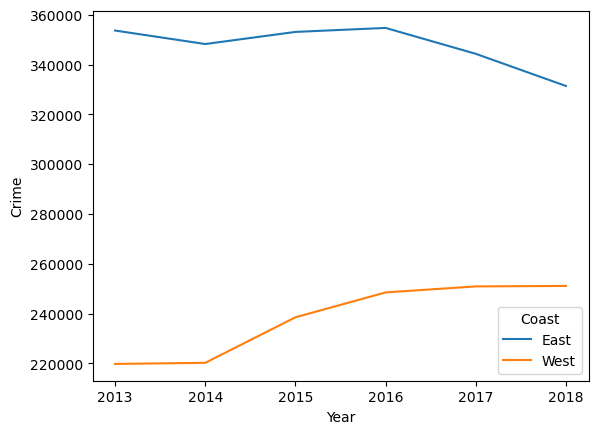

In [203]:
crime_east = (crime_df[crime_df['State_Name'].isin(East)]).loc[:, ['State_Name','Violent_Crime', 'Year']]
crime_east = duckdb.sql( """ Select Sum(Violent_Crime) AS Crime,
                        Year FROM crime_east GROUP BY Year""").df()
crime_east['Coast'] = 'East'

crime_west = crime_df[crime_df['State_Name'].isin(West)].loc[:, ['State_Name','Violent_Crime','Year']]
crime_west = duckdb.sql( """ Select  Sum(Violent_Crime) AS Crime,
                        Year FROM crime_west GROUP BY Year""").df()
crime_west['Coast']= 'West'

crime = pd.concat([crime_east, crime_west], axis=0)
print(crime)

sns.lineplot(data = crime, x = 'Year', y = 'Crime', hue = 'Coast')

       Rate  Year Coast
0  7.208333  2013  West
1  6.116667  2014  West
2  5.200000  2015  West
3  4.558333  2016  West
4  3.600000  2018  West
5  4.116667  2017  West
       Rate  Year Coast
0  6.116667  2014  East
1  5.200000  2015  East
2  4.558333  2016  East
3  3.600000  2018  East
4  7.208333  2013  East


<Axes: xlabel='Year', ylabel='Rate'>

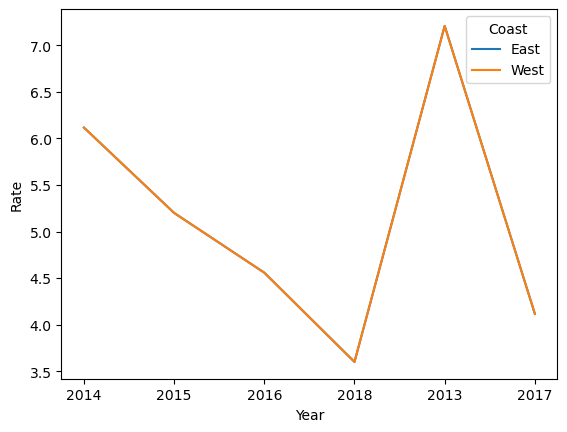

In [204]:
job2_df = pd.melt(job_df, id_vars = 'Area', var_name='Year', value_name= 'Rate').dropna()
job2_df
job_east = (job2_df[job2_df['Area'].isin(East)]).loc[:, ['Area','Rate', 'Year']]
job_east = duckdb.sql("""Select AVG(Rate) as Rate, Year FROM job_east GROUP BY Year""").df()
job_east['Coast']  = 'East'

job_west = (job2_df[job2_df['Area'].isin(West)]).loc[:, ['Area','Rate', 'Year']]
job_west = duckdb.sql("""Select AVG(Rate) as Rate, Year FROM job_east GROUP BY Year""").df()
job_west['Coast'] = 'West'
print(job_west)

job_fin= pd.concat([job_east, job_west], axis = 0)
print(job_fin.head())
sns.lineplot(data = job_fin, x = 'Year', y = 'Rate', hue = 'Coast')
